In [ ]:
from himalaya.kernel_ridge import KernelRidgeCV
import os
import json
import numpy as np
from config.dir import DATA_DIR, EM_DATA_DIR ,REPO_DIR
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.utils import generate_leave_one_run_out
from sklearn.model_selection import check_cv
import cortex
import numpy as np
import matplotlib.pyplot as plt

# Using a single session as a training 

In [3]:
subject = "sub-UTS02"
dir ='results/eng1000'
with open(os.path.join(REPO_DIR, dir,subject,'features_train.json'), "r") as f:
	X_train = json.load(f)
with open(os.path.join(REPO_DIR, dir,subject,'features_test.json'), "r") as f:
	X_test = json.load(f)
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)
#X_train = np.vstack((X_train, X_train))
print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3737, 985)
(n_samples_test, n_features) = (291, 985)


# Subject 2 for training & testing

In [4]:
subject = "sub-UTS02"
dir ='results/eng1000/'
with open(os.path.join(REPO_DIR, dir,subject,'fmri_train.json'), "r") as f:
	Y_train = json.load(f)
with open(os.path.join(REPO_DIR, dir,subject,'fmri_test.json'), "r") as f:
	Y_test = json.load(f)
Y_train = np.array(Y_train, dtype=float)
Y_test = np.array(Y_test, dtype=float)
print("(n_samples_train, n_voxels) =", Y_train.shape)
print("( n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (3737, 94251)
( n_samples_test, n_voxels) = (291, 94251)


In [5]:
with open(os.path.join(REPO_DIR, dir,subject,'run_on.json'), "r") as f:
	run_onsets = json.load(f)
run_onsets

[343, 710, 1064, 1464, 1894, 2252, 2674, 3078, 3433]

In [6]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [7]:
X_train_= X_train.astype("float32")
alphas = np.logspace(1, 20, 20)

# Create training model pipline 

In [8]:
pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

In [9]:
_ = pipeline.fit(X_train, Y_train)

# Scores of training and testing data set

In [10]:
scores_train = pipeline.score(X_train, Y_train)
print("(n_voxels train,) =", scores_train.shape)
scores_test = pipeline.score(X_test, Y_test)
print("(n_voxels test,) =", scores_test.shape)

(n_voxels train,) = (94251,)
(n_voxels test,) = (94251,)


Text(0.5, 0, 'R-squared')

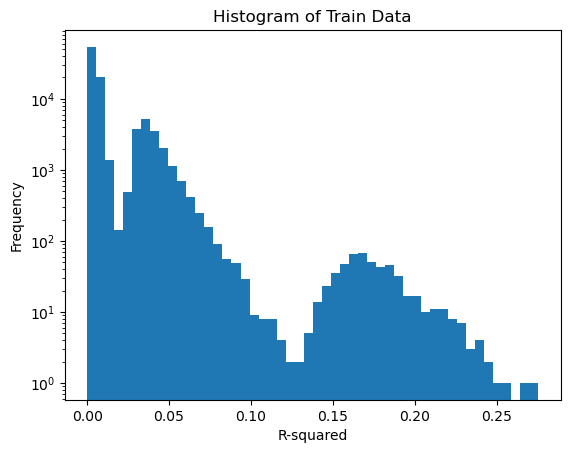

In [ ]:
import matplotlib.pyplot as plt
plt.hist(scores_train, bins=50, log=True)
plt.title("Histogram of Train Data")
plt.ylabel("Frequency")
plt.xlabel("R-squared")

Text(0.5, 0, 'R-squared')

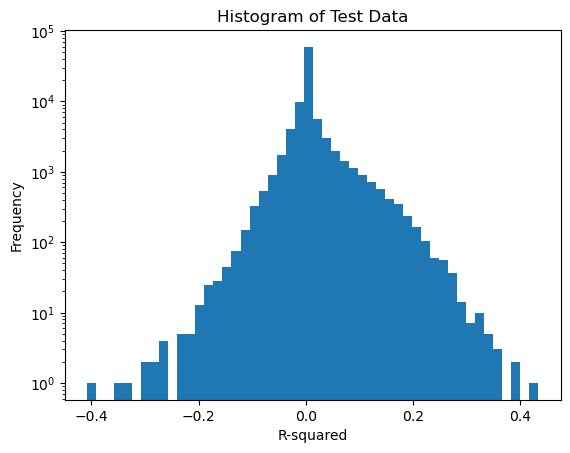

In [ ]:
plt.hist(scores_test, bins=50, log=True)
plt.title("Histogram of Test Data")
plt.ylabel("Frequency")
plt.xlabel("R-squared")

In [17]:
print("r-squared_average train =", np.mean(scores_train).round(4))
print("r-squared_average =", np.mean(scores_test).round(4))

r-squared_average train = 0.0108
r-squared_average = 0.0067


# Save trained data 

In [ ]:
#np.savetxt('train.txt', scores_train)
scores_train = np.loadtxt('train.txt', dtype=float)
#np.savetxt('test.txt', scores_test)
scores_test = np.loadtxt('test.txt', dtype=float)

# plotting on pycortex

In [ ]:
def set_pycortex_store(filestore):
    """Set the pycortex store to the specified directory."""
    cortex.database.default_filestore = filestore
    cortex.db.filestore = filestore
    cortex.db.reload_subjects()
    print(f"pycortex store set to {filestore}")


In [6]:
set_pycortex_store(os.path.join(DATA_DIR, 'ds003020/derivative/pycortex-db'))

pycortex store set to /Users/genevievelam/Documents/GitHub/ds003020/derivative/pycortex-db


RuntimeError: Inkscape doesn't seem to be installed on this system.SVGOverlay.get_texture requires inkscape.Please make sure that inkscape is installed and that is accessible from the terminal.

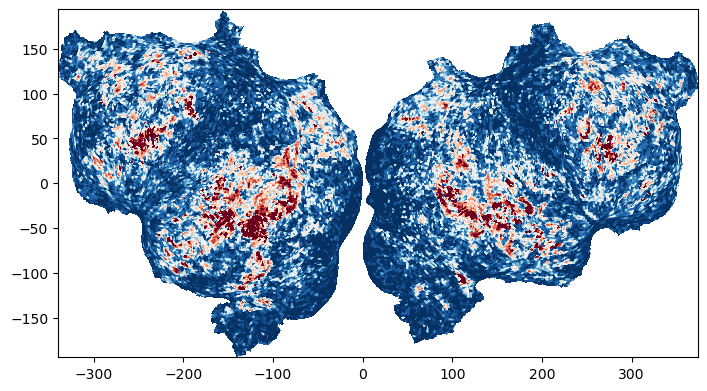

In [7]:
subject = 'UTS02'
xfm = 'UTS02_auto'

# First create example voxel data for this subject and transform
voxel_data = scores_train
voxel_vol = cortex.Volume(voxel_data, subject, xfm)

# Then we have to get a mapper from voxels to vertices for this transform
mapper = cortex.get_mapper(subject, xfm, 'line_nearest', recache=True)

# Just pass the voxel data through the mapper to get vertex data
vertex_map = mapper(voxel_vol)

# You can plot both as you would normally plot Volume and Vertex data
cortex.quickshow(voxel_vol)
plt.show()

Caching mapper...


RuntimeError: Inkscape doesn't seem to be installed on this system.SVGOverlay.get_texture requires inkscape.Please make sure that inkscape is installed and that is accessible from the terminal.

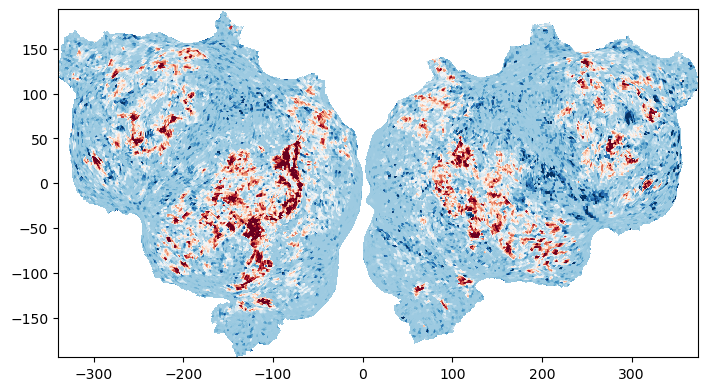

In [ ]:
# First create example voxel data for this subject and transform
voxel_data = scores_test
voxel_vol = cortex.Volume(voxel_data, subject, xfm)

# Then we have to get a mapper from voxels to vertices for this transform
mapper = cortex.get_mapper(subject, xfm,  recache=True)

# Just pass the voxel data through the mapper to get vertex data
vertex_map = mapper(voxel_vol)

# You can plot both as you would normally plot Volume and Vertex data
cortex.quickshow(voxel_vol)
plt.show()

In [ ]:
backend = set_backend("torch_cuda", on_error="warn")
scores_test = backend.to_numpy(scores_test)

/opt/anaconda3/envs/naturalistic/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


<Axes: xlabel='log10(alpha)', ylabel='Number of targets'>

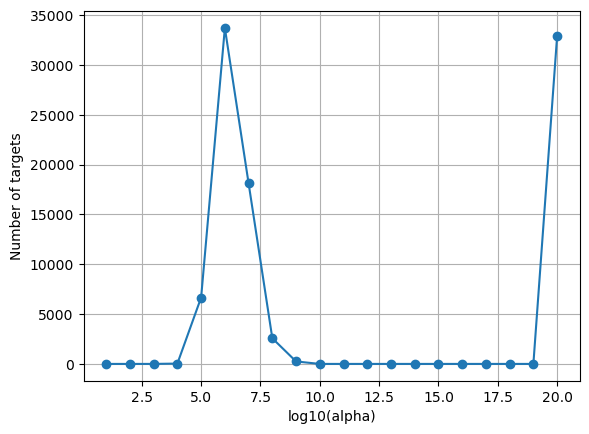

In [19]:
from himalaya.viz import plot_alphas_diagnostic
best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
#plt.show()

In [20]:
primal_coef = pipeline[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_delays * n_features, n_voxels) =", primal_coef.shape)

(n_delays * n_features, n_voxels) = (3940, 94251)


In [21]:
primal_coef /= np.linalg.norm(primal_coef, axis=0)[None]
primal_coef *= np.sqrt(np.maximum(0, scores_test))[None]

In [22]:
# split the ridge coefficients per delays
delayer = pipeline.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)
del primal_coef

# average over delays
average_coef = np.mean(primal_coef_per_delay, axis=0)
print("(n_features, n_voxels) =", average_coef.shape)
del primal_coef_per_delay

(n_delays, n_features, n_voxels) = (4, 985, 94251)
(n_features, n_voxels) = (985, 94251)


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(average_coef.T)
components = pca.components_
print("(n_components, n_features) =", components.shape)

(n_components, n_features) = (4, 985)


In [24]:
print("PCA explained variance =", pca.explained_variance_ratio_)

PCA explained variance = [0.18034443 0.15147918 0.07549113 0.06679695]


In [ ]:
# transform with the fitted PCA
average_coef_transformed = pca.transform(average_coef.T).T
print("(n_components, n_voxels) =", average_coef_transformed.shape)
del average_coef

# We make sure vmin = -vmax, so that the colormap is centered on 0.
vmax = np.percentile(np.abs(average_coef_transformed), 99.9)

# plot the primal weights projected on the first principal component.
ax = plot_flatmap_from_mapper(average_coef_transformed[0], mapper_file,
                              vmin=-vmax, vmax=vmax, cmap='coolwarm')
plt.show()